# 顔の表情を認識させるコードを書いてみた

このコードは顔の表情を認識させるアプリを書く時の参考のために使用している。とりあえず、手頃なデータセットを使用してみた。

まずは使用するモジュールを紹介する。今回はpy-featを使った。

In [6]:
import feat
import cv2
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import re
import os

次に検証に使用するデータセットについても触れる。今回使用したのは https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition/ からダウンロードしてきた画像データである。
画像データの一つを紹介すると、

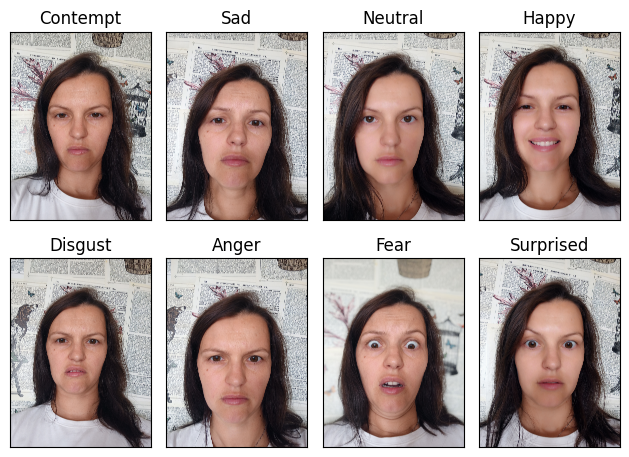

In [7]:
dataset_path = './dataset/images/0'
dataset_list = list(pathlib.Path(dataset_path).glob('**/*.jpg'))
row_num = 2
column_num = 4
fig, axes = plt.subplots(row_num, column_num, tight_layout = True)

for i in range(len(dataset_list)):
    
    img_file_name = str(dataset_list[i])
    img = cv2.imread(img_file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    row = int(i)//int(column_num)
    column = int(i)%int(column_num)
    
    axes[row, column].xaxis.set_major_locator(plt.NullLocator())
    axes[row, column].yaxis.set_major_locator(plt.NullLocator())
    axes[row, column].imshow(img, cmap="bone")
    axes[row, column].set_title(img_file_name.removeprefix('dataset/images/0/').removesuffix('.jpg'))

plt.show()

このデータセットを利用する。py-featを用いてとりあえずAngerの画像を利用してどのような動作をするか確認。

In [8]:
from feat import Detector
# rf: https://py-feat.org/content/intro.html#available-models
face_model = "retinaface"
landmark_model = "mobilefacenet"
au_model = "xgb"
emotion_model = "resmasknet"
facepose_model="img2pose"

detector = Detector(
    face_model=face_model,
    landmark_model=landmark_model,
    au_model=au_model,
    emotion_model=emotion_model
    #facepose_model=facepose_model
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


[<Figure size 1500x700 with 3 Axes>]

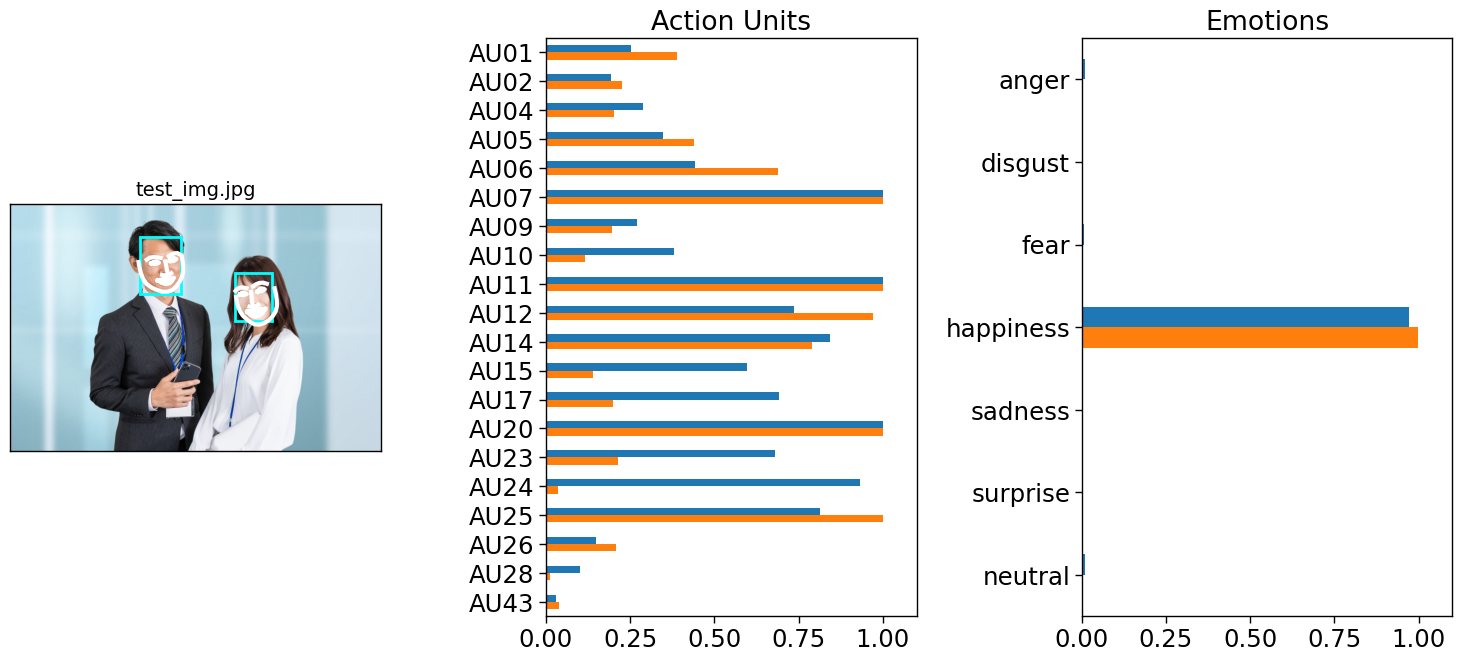

In [9]:
#img_path = 'dataset/images/0/Neutral.jpg'
img_path = 'dataset/test_img.jpg'
#fig, axes = plt.subplots()
#img = cv2.imread(img_path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_prediction = detector.detect_image(img_path)
# Show results
image_prediction
image_prediction.plot_detections()

上記の結果から分かるようにtest_img.jpgでしっかりhappinessと分類されている。

print(image_prediction.facebox)

In [10]:
print(image_prediction.facebox)

    FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore
0  224.110345   57.895904      70.292717       97.089372   0.996927
1  387.946291  119.384660      64.687500       82.783191   0.993703


/usr/local/lib/python3.11/dist-packages/feat/data.py:618: DeprecationWarning: Fex.facebox has been renamed to Fex.faceboxes
  warnings.warn(


In [11]:
img_path2 = 'emojis/anger.jpeg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

#plt.imshow(img)
img2 = cv2.imread(img_path2)
row, column, channel = img.shape
img2 = cv2.resize(img2, (column, row))
#img = img2
#plt.imshow(img)

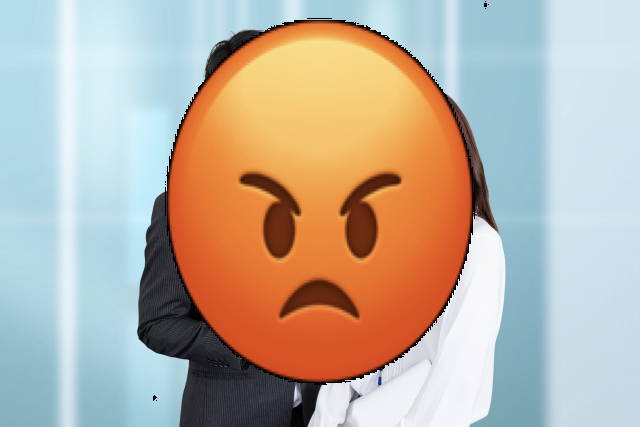

In [12]:
from PIL import Image

def overlay_images(background_path, overlay_path, output_path):
    # 背景画像を開く
    background = Image.open(background_path)

    # 重ねる画像を開く
    overlay = Image.open(overlay_path)

    # 重ねる画像のサイズを背景画像に合わせる
    overlay = overlay.resize(background.size, Image.LANCZOS)

    # 重ねる画像の背景を透明にする
    overlay = overlay.convert("RGBA")
    data = overlay.getdata()
    new_data = []
    for item in data:
        # 黒いピクセルを透明にする（閾値以下のもの）
        if item[:3] == (0, 0, 0):
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    overlay.putdata(new_data)

    # 画像を合成
    result = Image.alpha_composite(background.convert("RGBA"), overlay)
    result = result.convert("RGB")

    # 結果を保存
    #result.save(output_path, "PNG")
    result.show()

if __name__ == "__main__":
    background_image_path = 'dataset/test_img.jpg'  # 背景画像のパス
    overlay_image_path = 'emojis/anger.jpeg'  # 重ねる画像のパス
    output_image_path = "output.png"  # 出力画像のパス
    
    overlay_images(background_image_path, overlay_image_path, output_image_path)


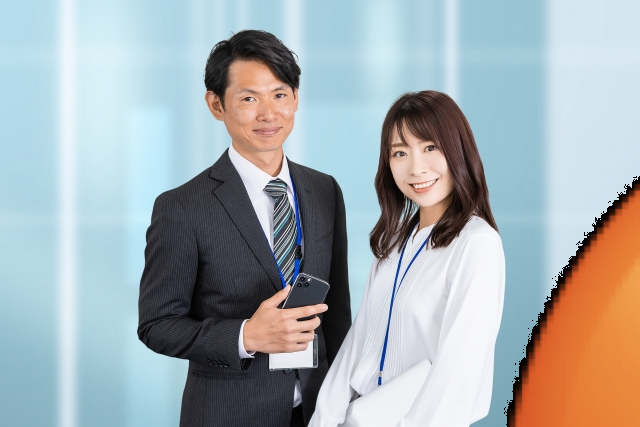

In [13]:
from PIL import Image

def overlay_and_crop(base_path, overlay_path, output_path):
    # ベース画像を開く
    base_image = Image.open(base_path)

    # 重ねる画像を開く
    overlay_image = Image.open(overlay_path)

    # ベース画像のサイズを取得
    base_width, base_height = base_image.size

    # 背景を作成（3倍の大きさ、背景は黒）
    background = Image.new("RGBA", (base_width * 3, base_height * 3), (0, 0, 0, 0))

    # ベース画像を中央に貼り付け
    background.paste(base_image, (base_width, base_height))
    
    # 重ねる画像の背景を透明にする
    overlay_image = overlay_image.convert("RGBA")
    data = overlay_image.getdata()
    new_data = []
    for item in data:
        # 黒いピクセルを透明にする（閾値以下のもの）
        if item[:3] == (0, 0, 0):
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    overlay_image.putdata(new_data)

    # 重ねる画像を適当な位置に貼り付け
    overlay_position = (int(base_width * 1.0), int(base_height * 1.0))
    background.paste(overlay_image, overlay_position, overlay_image)

    # 元の中央のbaseの画像の部分だけをくり抜く
    crop_box = (base_width, base_height, base_width * 2, base_height * 2)
    result = background.crop(crop_box)

    # 結果を保存
    result = result.convert("RGB")
    result.show()
    #result.save(output_path, "PNG")

if __name__ == "__main__":
    background_image_path = 'dataset/test_img.jpg'  # 背景画像のパス
    overlay_image_path = 'emojis/anger.jpeg'  # 重ねる画像のパス
    output_image_path = "output.png"  # 出力画像のパス

    overlay_and_crop(background_image_path, overlay_image_path, output_image_path)
    

a
emojis/happiness.jpeg
a
emojis/happiness.jpeg


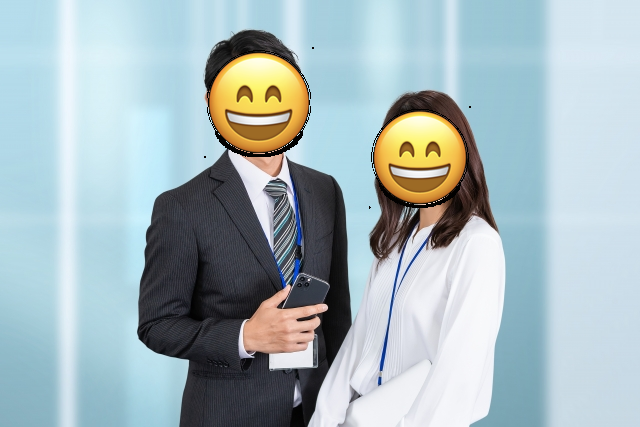

In [37]:
from PIL import Image

#def overlay_resize(overlay_path, object_width):
    
    #return overlay
    
def create_overlay(overlay_path, object_width):
    # 重ねる画像を開く
    #overlay = Image.open(rgb_overlay_image_path)
    #overlay = overlay.resize((row, column), Image.LANCZOS)
    # 重ねる画像の背景を透明にする
    
    overlay = Image.open(overlay_path)
    width, height = overlay.size
    overlay = overlay.resize((int(object_width), int(height * object_width / width)), Image.LANCZOS)
    overlay = overlay.convert("RGBA")
    data = overlay.getdata()
    new_data = []
    for item in data:
        # 黒いピクセルを透明にする（閾値以下のもの）
        if item[:3] == (0, 0, 0):
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    overlay.putdata(new_data)
    return overlay


def overlay_images(background_path, overlay_path, dataset):
    # 背景画像を開く
    base = Image.open(background_path)
    
    
    # 重ねる画像のサイズを背景画像に合わせる
    #overlay = overlay.resize(background.size, Image.LANCZOS)

    # 重ねる画像の背景を透明にする
    """
    overlay = overlay.convert("RGBA")
    data = overlay.getdata()
    new_data = []
    for item in data:
        # 黒いピクセルを透明にする（閾値以下のもの）
        if item[:3] == (0, 0, 0):
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    overlay.putdata(new_data)
    """
    base_width, base_height = base.size
    background = Image.new("RGBA", (base_width * 3, base_height * 3), (0, 0, 0, 0))

    # ベース画像を中央に貼り付け
    background.paste(base, (base_width, base_height))
    background.convert("RGBA")
    for i in range(len(dataset)):
        
        # 画像を合成
        data = dataset.iloc[i]
        print("a")
        path = os.path.join('emojis', data.emotions.idxmax() + '.jpeg')
        print(path)
        overlay = create_overlay(path, 3 * data.FaceRectWidth)
        #width, height = overlay.size
        
        #overlay_position = (int(base_width * 1.0), int(base_height * 1.0))
        #background.paste(overlay, overlay_position, overlay)
        
        overlay_width, overlay_height = overlay.size 
        overlay_position = (int(base_width + data.FaceRectX + (data.FaceRectWidth - overlay_width) / 2.0), int(base_height + data.FaceRectY + (data.FaceRectHeight - overlay_height) / 2.0))
        background.paste(overlay, overlay_position, overlay)
        #background = Image.alpha_composite(background, overlay)
        
    crop_box = (base_width, base_height, base_width * 2, base_height * 2)
    result = background.crop(crop_box)
    result = result.convert("RGB")

    # 結果を保存
    #result.save(output_path, "PNG")
    result.show()

if __name__ == "__main__":
    background_image_path = 'dataset/test_img.jpg'  # 背景画像のパス
    overlay_image_path = 'emojis/anger.jpeg'  # 重ねる画像のパス
    output_image_path = "output.png"  # 出力画像のパス
    
    overlay_images(background_image_path, overlay_image_path, image_prediction)


In [15]:
print(image_prediction.facebox)

    FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore
0  224.110345   57.895904      70.292717       97.089372   0.996927
1  387.946291  119.384660      64.687500       82.783191   0.993703


/usr/local/lib/python3.11/dist-packages/feat/data.py:618: DeprecationWarning: Fex.facebox has been renamed to Fex.faceboxes
  warnings.warn(


In [18]:
print(image_prediction.emotions)
for i in range(len(image_prediction.emotions)):
    #print(np.argmax(image_prediction.iloc[i].emotions))
    print(image_prediction.iloc[i].emotions.idxmax())

      anger   disgust      fear  happiness   sadness  surprise  neutral
0  0.009595  0.000593  0.005668   0.970284  0.000475  0.004626  0.00876
1  0.000182  0.000006  0.000200   0.997884  0.000179  0.001110  0.00044
happiness
happiness


In [35]:
from PIL import Image
def create_overlay(rgb_overlay_image_path, row, column):
    # 重ねる画像を開く
    overlay = Image.open(rgb_overlay_image_path)
    overlay = overlay.resize((row, column), Image.LANCZOS)
    # 重ねる画像の背景を透明にする
    overlay = overlay.convert("RGBA")
    data = overlay.getdata()
    new_data = []
    for item in data:
        # 黒いピクセルを透明にする（閾値以下のもの）
        if item[:3] == (0, 0, 0):
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    overlay.putdata(new_data)
    return overlay


def overlay_images(background_path, overlay_path, output_path, dataset):
    # 背景画像を開く
    base = Image.open(background_path)
    
    
    # 重ねる画像のサイズを背景画像に合わせる
    #overlay = overlay.resize(background.size, Image.LANCZOS)

    # 重ねる画像の背景を透明にする
    """
    overlay = overlay.convert("RGBA")
    data = overlay.getdata()
    new_data = []
    for item in data:
        # 黒いピクセルを透明にする（閾値以下のもの）
        if item[:3] == (0, 0, 0):
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    overlay.putdata(new_data)
    """
    base_width, base_height = base.size
    background = Image.new("RGBA", (base_width * 3, base_height * 3), (0, 0, 0, 0))

    # ベース画像を中央に貼り付け
    background.paste(base, (base_width, base_height))
    background.convert("RGBA")
    
    
    row = data.FaceRectX
    
    overlay = create_overlay(overlay_image_path, )
    for i in range(len(dataset)):
        
        # 画像を合成
        data = dataset.iloc[i]
        rectrow = data.FaceRectWidth
        column = int(data.FaceRectHeight
        row = rectrow
        
        # model.add(layers.Dense(64, activation=opt))
        overlay_image_path = os.path.join('emojis', data.emotions.idxmax() + '.jpeg')
        overlay = create_overlay(overlay_image_path, )
        height, width = overlay.size
        overlay_position = (int(data.FaceRectX + (data.R)), int())
        background = Image.alpha_composite(background, overlay)
        
    result = background.convert("RGB")

    # 結果を保存
    #result.save(output_path, "PNG")
    result.show()

if __name__ == "__main__":
    background_image_path = 'dataset/test_img.jpg'  # 背景画像のパス
    overlay_image_path = 'emojis/anger.jpeg'  # 重ねる画像のパス
    output_image_path = "output.png"  # 出力画像のパス
    
    overlay_images(background_image_path, overlay_image_path, output_image_path)
    

224.11034470140518
387.94629134953163


In [ ]:
from PIL import Image
import cv2 as cv
base_path = 'dataset/test_img.jpg' # ベース画像
logo_path = 'emojis/anger.jpeg' # 重ねる透過画像
out_path = 'out.jpg' # 出力ファイル

#base = Image.open(base_path)
#logo = Image.open(logo_path)
base = cv.imread(base_path)
logo = cv.imread(logo_path)
row, column, _ = base.shape
logo = cv.resize(logo, (column, row))
# base.paste(logo, (0, 0))
cv_rgb_bg_image = cv.cvtColor(base, cv.COLOR_BGR2RGB)
pil_rgb_bg_image = Image.fromarray(cv_rgb_bg_image)
pil_rgba_bg_image = pil_rgb_bg_image.convert('RGBA')
        # オーバーレイ画像
cv_rgb_ol_image = cv.cvtColor(logo, cv.COLOR_BGRA2RGBA)
pil_rgb_ol_image = Image.fromarray(cv_rgb_ol_image)
pil_rgba_ol_image = pil_rgb_ol_image.convert('RGBA')
pil_rgba_ol_image.show()
        # composite()は同サイズ画像同士が必須のため、合成用画像を用意
pil_rgba_bg_temp = Image.new('RGBA', pil_rgba_bg_image.size,
                                     (255, 255, 255, 0))
        # 座標を指定し重ね合わせる
pil_rgba_bg_temp.paste(pil_rgba_ol_image, (0, 0), pil_rgba_ol_image)
result_image = Image.alpha_composite(pil_rgba_bg_image, pil_rgba_bg_temp)
#result_image.show()
#base.paste(logo, (0, 0), logo)
#base.show()
#base.save(out_path)

In [ ]:
path = "emojis/anger.jpeg"
src = cv2.imread(path)
 
# Point 1: 白色部分に対応するマスク画像を生成
mask = np.all(src[:,:,:] == [0, 0, 0], axis=-1)
 
# Point 2: 元画像をBGR形式からBGRA形式に変換
dst = cv2.cvtColor(src, cv2.COLOR_BGR2BGRA)
 
# Point3: マスク画像をもとに、白色部分を透明化
dst[mask,3] = 0
 
# png画像として出力
#cv2.imwrite("dst.png", dst)

plt.imshow(dst)

In [ ]:
img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

img2gray_src = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2RGB)
plt.imshow(img2gray_src)

In [ ]:
img1_bg = cv2.bitwise_and(img,img,mask = mask_inv)
img1_bg_src = cv2.cvtColor(img1_bg, cv2.COLOR_BGR2RGB)
plt.imshow(img1_bg_src)

In [ ]:
path = "emojis/anger.jpeg"
src = cv2.imread(path)
 
# Point 1: 白色部分に対応するマスク画像を生成
mask = np.all(src[:,:,:] == [0, 0, 0], axis=-1)
 
# Point 2: 元画像をBGR形式からBGRA形式に変換
dst = cv2.cvtColor(src, cv2.COLOR_BGR2BGRA)
 
# Point3: マスク画像をもとに、白色部分を透明化
dst[mask,3] = 0
 
# png画像として出力
#cv2.imwrite("dst.png", dst)

plt.imshow(dst)